In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR


## Load Mnist Datasets

In [67]:
'''
transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
'''
BATCH_SIZE = 128

# define tranforms on the training set
# include resizing and random rotations
train_transform = transforms.Compose([transforms.Resize((32,32)),
                                    # transforms.RandomRotation(degrees=(10, -10), fill=(0,)),
                                      transforms.ToTensor(),
                                      # normalize using pretrained values
                                      transforms.Normalize((0.1307,), (0.3081,))])
# define transforms on the test set
test_transform = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     # normalize using pretrained values
                                     transforms.Normalize((0.1307,), (0.3081,))])
# load the data
train = datasets.MNIST(root='./data', train=True, download=False, transform = train_transform)
test = datasets.MNIST(root='./data', train=False, download=False, transform = test_transform)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.95

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = test_transform

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)

## VGG

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        vgg_firstlayer=models.vgg16_bn(pretrained = False).features[0] #load just the first conv layer

        vgg = models.vgg16_bn(pretrained = False).features[1:44] #load upto the classification layers except first conv layer
        
        w1=vgg_firstlayer.state_dict()['weight'][:,0,:,:]
        w2=vgg_firstlayer.state_dict()['weight'][:,1,:,:]
        w3=vgg_firstlayer.state_dict()['weight'][:,2,:,:]
        w4=w1+w2+w3 # add the three weigths of the channels
        w4=w4.unsqueeze(1)# make it 4 dimensional

        #nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
        first_conv=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True) #create a new conv layer
        first_conv.weigth=torch.nn.Parameter(w4, requires_grad=True) #initialize  the conv layer's weigths with w4
        first_conv.bias=torch.nn.Parameter(vgg_firstlayer.state_dict()['bias'], requires_grad=True) #initialize  the conv layer's weigths with vgg's first conv bias

        first_conv=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)] #create a new conv layer

        first_conv.extend(list(vgg))  
        print()

        self.feature = nn.Sequential(*first_conv)
 
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )        
               
        #vgg = first_conv 
        #print(self.vgg)
        #self.fc1 = nn.Linear(7*7*512, 1000)
        #self.fc2 = nn.Linear(1000, 2)

    def forward(self, x):
        #x=self.first_convlayer(x)
        x = self.vgg(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [3]:
VGG_model = Net()
VGG_model

Net(
  (vgg): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, ker

In [4]:
print("Model's state_dict:")
#print(VGG_model.state_dict().keys())
for param_tensor in VGG_model.state_dict():
    print(param_tensor, "\t", VGG_model.state_dict()[param_tensor].size())

Model's state_dict:
vgg.0.weight 	 torch.Size([64, 1, 3, 3])
vgg.0.bias 	 torch.Size([64])
vgg.1.weight 	 torch.Size([64])
vgg.1.bias 	 torch.Size([64])
vgg.1.running_mean 	 torch.Size([64])
vgg.1.running_var 	 torch.Size([64])
vgg.1.num_batches_tracked 	 torch.Size([])
vgg.3.weight 	 torch.Size([64, 64, 3, 3])
vgg.3.bias 	 torch.Size([64])
vgg.4.weight 	 torch.Size([64])
vgg.4.bias 	 torch.Size([64])
vgg.4.running_mean 	 torch.Size([64])
vgg.4.running_var 	 torch.Size([64])
vgg.4.num_batches_tracked 	 torch.Size([])
vgg.7.weight 	 torch.Size([128, 64, 3, 3])
vgg.7.bias 	 torch.Size([128])
vgg.8.weight 	 torch.Size([128])
vgg.8.bias 	 torch.Size([128])
vgg.8.running_mean 	 torch.Size([128])
vgg.8.running_var 	 torch.Size([128])
vgg.8.num_batches_tracked 	 torch.Size([])
vgg.10.weight 	 torch.Size([128, 128, 3, 3])
vgg.10.bias 	 torch.Size([128])
vgg.11.weight 	 torch.Size([128])
vgg.11.bias 	 torch.Size([128])
vgg.11.running_mean 	 torch.Size([128])
vgg.11.running_var 	 torch.Size([128

In [6]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = VGG(in_planes=1,num_classes=10).to(device)
#model = resnet20().to(device)

#model = resnet44().to(device)

In [7]:
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

VGG_model = VGG_model.to(device) 
#VGG_model

#model = models.vgg16_bn(pretrained=False)# pretrained=False just for debug reasons


Net(
  (vgg): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, ker

In [90]:
#model2 = models.vgg16_bn(pretrained=False)# pretrained=False just for debug reasons

#model2.features[0].in_channels = 1
#model2.features

#first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]

#first_conv_layer.extend(list(model2.features))  
#model2.features= nn.Sequential(*first_conv_layer )  

#model2.classifier[0].in_features= 512
#model2.classifier[0].out_features= 128

#model2.classifier[3].in_features= 128
#model2.classifier[3].out_features= 128

#model2.classifier[6].in_features= 128
#model2.classifier[6].out_features= 10
#model2.classifier

#del model2.avgpool

#model2 = model.to(device) 
#model2

In [65]:
#print("Model's state_dict:")
#print(model2.state_dict().keys())
#for param_tensor in model2.state_dict():
    #print(param_tensor, "\t", model2.state_dict()[param_tensor].size())

In [66]:
#model.parameters()

In [12]:
#learn.destroy()
#torch.cuda.empty_cache()

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

#model = models.vgg16(pretrained=False)# pretrained=False just for debug reasons

#num_features = model.classifier[6].in_features
#features = list(model.classifier.children())[:-1] # Remove last layer
#features.extend([nn.Linear(num_features, 10)]) # Add our layer with 4 outputs
#model.classifier = nn.Sequential(*features) # Replace the model classifier

#x = torch.randn(1, 1, 224, 224)

#first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]

#first_conv_layer.extend(list(model.features))  
#model.features= nn.Sequential(*first_conv_layer )  
#output = model(x)

#model = model.to(device) 

#model


#model = VGG(in_planes=1,num_classes=10).to(device)
#model = resnet20().to(device)

#model = resnet44().to(device)


#model = model.to(device)


In [13]:
#type(model.children())
#model.children()

In [14]:
#print(model)

In [10]:
from torchsummary import summary

summary(VGG_model, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [11]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(VGG_model.parameters(), lr = 0.1, momentum = 0.9, weight_decay=0.0005)

# scheduler for VGG
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10, 20], last_epoch= -1)


In [12]:
def calculate_accuracy(y_pred, y):
    '''get model accuracy'''
    p = y_pred.argmax(1, keepdim = True)
    acc = p.eq(y.view_as(p)).sum().float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    '''
    function to be called for training and collect 
    model loss and model accuracy
    and perform a training step

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # set to training mode
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        # update loss and accuracy values
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    '''
    function to be called for evaluating and collect 
    model val loss and model val accuracy

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x).to(device)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

EPOCHS = 5
train_loss_list = []
train_acc_list_VGG = []

val_loss_list = []
val_acc_list_VGG = []

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(VGG_model, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(VGG_model, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list.append(train_loss)
    train_acc_list_VGG.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list_VGG.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'epoch: {epoch+1:02}, Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t train accuracy: {train_acc:.3f} | train loss: {train_loss:.3f} | ')
    print(f'\t val accuracy: {val_acc:.3f} | val losss: {val_loss:.3f}')

epoch: 01, Time: 3m 19s
	 train accuracy: 0.936 | train loss: 0.239 | 
	 val accuracy: 0.979 | val losss: 0.085
epoch: 02, Time: 3m 18s
	 train accuracy: 0.984 | train loss: 0.071 | 
	 val accuracy: 0.988 | val losss: 0.054
epoch: 03, Time: 3m 18s
	 train accuracy: 0.986 | train loss: 0.058 | 
	 val accuracy: 0.986 | val losss: 0.051
epoch: 04, Time: 3m 18s
	 train accuracy: 0.987 | train loss: 0.054 | 
	 val accuracy: 0.980 | val losss: 0.075
epoch: 05, Time: 3m 18s
	 train accuracy: 0.987 | train loss: 0.054 | 
	 val accuracy: 0.988 | val losss: 0.049


In [ ]:
def get_preds(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_preds(VGG_model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [ ]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list, label = 'validation loss')
plt.legend()
plt.title('Resnet, Cross Entropy Loss across Epochs')

In [ ]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list_VGG, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_VGG, label = 'validation accuracy')
plt.legend()
plt.title('Resnet, Accuracy across Epochs')

In [ ]:
def labels_accuracy(y, y_pred):
    crr = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            crr += 1
    return crr/len(y)


labels_accuracy(labels.numpy(), pred_labels.numpy())

In [ ]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
def show_incorrect_preds(incorrect, classes, n_images, normalize = False):

    rows = 1 
    cols = n_images  

    fig = plt.figure(figsize = (10, 10))
    fig.tight_layout()
    for i in range(cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image[0]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label][0]
        incorrect_class = classes[incorrect_label][0]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true class: {true_class}\n' \
                     f'pred class: {incorrect_class}')
        ax.axis('off')

show_incorrect_preds(incorrect_examples, classes, 5)

## Resnet

In [25]:
class ResNetBlock(nn.Module):
    '''
    A class for a Basic ResNet Block to be used in the ResNet class
    Suited only for CIFAR10 and MNIST
    Defined according to 4.2 of the ResNet paper

    in_planes (int): number of input channels
    planes (int): number of output channels
    stride (int): stride of the convolutional layer
    '''
    
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes)
              )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
class ResNet(nn.Module):
    '''
    ResNet Class, building on a ResNet Block to make a full network

    num_blocks (int):       multiplier used to stack layers, 
                            total number of layers is 6*num_blocks + 2
    channels (int):         number of colour_channels present in data
    num_classes (int):      number of existing classes in data
    '''
    def __init__(self, block, num_blocks, channels, num_classes):
        super(ResNet, self).__init__()
        # initialize number of output channels at 16
        self.in_planes = 16

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.stack_layer(block, 16, num_blocks, stride=1)
        self.layer2 = self.stack_layer(block, 32, num_blocks, stride=2)
        self.layer3 = self.stack_layer(block, 64, num_blocks, stride=2)
        self.linear = nn.Linear(64, num_classes)
    
    def stack_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            # update the number of output channels
            self.in_planes = planes 

        return nn.Sequential(*layers)

    def forward(self, x):
        # creating the network
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        # reshaping
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def resnet20():
    return ResNet(ResNetBlock, num_blocks = 3, channels = 1, num_classes = 10)


def resnet44():
    return ResNet(ResNetBlock, 7, channels = 1, num_classes = 10)

In [2]:
#model = resnet20()
#model

In [3]:
#print("Model's state_dict:")
#print(model.state_dict().keys())
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [30]:
#resModel2 = models.resnet34(pretrained=False)# pretrained=False just for debug reasons
#resModel2


In [40]:
resModel = models.resnet18(num_classes=10, pretrained=False)# pretrained=False just for debug reasons
resModel.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)

resModel

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
print("Model's state_dict:")
#print(model.state_dict().keys())
for param_tensor in resModel.state_dict():
    print(param_tensor, "\t", resModel.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 3, 3])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

In [44]:
model = resModel.to(device)


In [45]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay=0.0005)
# scheduler for VGG
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10, 20], last_epoch= -1)
# scheduler for ResNet
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[8,15], last_epoch= -1)

In [46]:
summary(model, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 18]             576
       BatchNorm2d-2           [-1, 64, 18, 18]             128
              ReLU-3           [-1, 64, 18, 18]               0
         MaxPool2d-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 9, 9]          36,864
       BatchNorm2d-6             [-1, 64, 9, 9]             128
              ReLU-7             [-1, 64, 9, 9]               0
            Conv2d-8             [-1, 64, 9, 9]          36,864
       BatchNorm2d-9             [-1, 64, 9, 9]             128
             ReLU-10             [-1, 64, 9, 9]               0
       BasicBlock-11             [-1, 64, 9, 9]               0
           Conv2d-12             [-1, 64, 9, 9]          36,864
      BatchNorm2d-13             [-1, 64, 9, 9]             128
             ReLU-14             [-1, 6

In [48]:
def calculate_accuracy(y_pred, y):
    '''get model accuracy'''
    p = y_pred.argmax(1, keepdim = True)
    acc = p.eq(y.view_as(p)).sum().float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    '''
    function to be called for training and collect 
    model loss and model accuracy
    and perform a training step

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # set to training mode
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        # update loss and accuracy values
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    '''
    function to be called for evaluating and collect 
    model val loss and model val accuracy

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x).to(device)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

EPOCHS = 10
train_loss_list = []
train_acc_list_Resnet = []

val_loss_list = []
val_acc_list_Resnet = []

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list.append(train_loss)
    train_acc_list_Resnet.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list_Resnet.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'epoch: {epoch+1:02}, Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t train accuracy: {train_acc:.3f} | train loss: {train_loss:.3f} | ')
    print(f'\t val accuracy: {val_acc:.3f} | val losss: {val_loss:.3f}')

epoch: 01, Time: 1m 41s
	 train accuracy: 0.983 | train loss: 0.052 | 
	 val accuracy: 0.967 | val losss: 0.100
epoch: 02, Time: 1m 41s
	 train accuracy: 0.984 | train loss: 0.049 | 
	 val accuracy: 0.981 | val losss: 0.064
epoch: 03, Time: 1m 41s
	 train accuracy: 0.986 | train loss: 0.044 | 
	 val accuracy: 0.964 | val losss: 0.122
epoch: 04, Time: 1m 41s
	 train accuracy: 0.994 | train loss: 0.020 | 
	 val accuracy: 0.990 | val losss: 0.040
epoch: 05, Time: 1m 41s
	 train accuracy: 0.996 | train loss: 0.013 | 
	 val accuracy: 0.989 | val losss: 0.035
epoch: 06, Time: 1m 41s
	 train accuracy: 0.997 | train loss: 0.011 | 
	 val accuracy: 0.991 | val losss: 0.035
epoch: 07, Time: 1m 42s
	 train accuracy: 0.998 | train loss: 0.008 | 
	 val accuracy: 0.992 | val losss: 0.031
epoch: 08, Time: 1m 42s
	 train accuracy: 0.998 | train loss: 0.007 | 
	 val accuracy: 0.991 | val losss: 0.031
epoch: 09, Time: 1m 41s
	 train accuracy: 0.999 | train loss: 0.006 | 
	 val accuracy: 0.990 | val losss

In [49]:
def get_preds(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [50]:
images, labels, probs = get_preds(model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

C:\Users\Moad\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


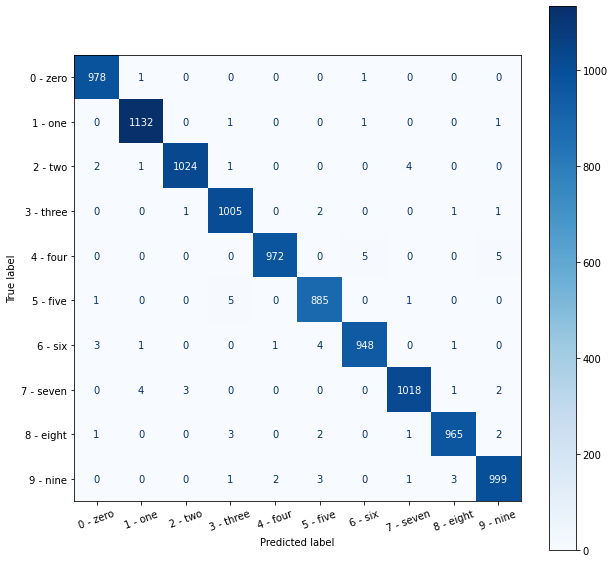

In [52]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'Resnet, Cross Entropy Loss across Epochs')

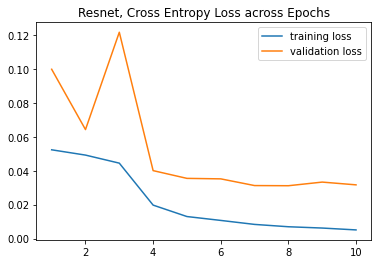

In [53]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list, label = 'validation loss')
plt.legend()
plt.title('Resnet, Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'Resnet, Accuracy across Epochs')

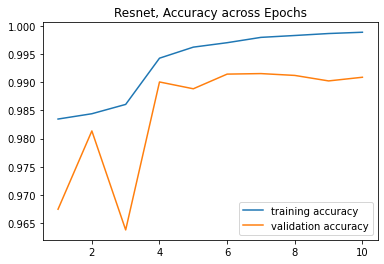

In [55]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list_Resnet, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_Resnet, label = 'validation accuracy')
plt.legend()
plt.title('Resnet, Accuracy across Epochs')

In [56]:
def labels_accuracy(y, y_pred):
    crr = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            crr += 1
    return crr/len(y)


labels_accuracy(labels.numpy(), pred_labels.numpy())

0.9926

In [59]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [60]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

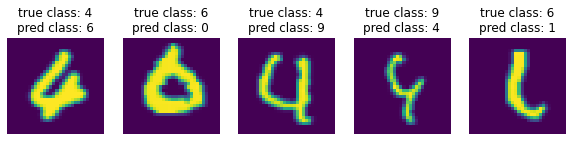

In [61]:
def show_incorrect_preds(incorrect, classes, n_images, normalize = False):

    rows = 1 
    cols = n_images  

    fig = plt.figure(figsize = (10, 10))
    fig.tight_layout()
    for i in range(cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image[0]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label][0]
        incorrect_class = classes[incorrect_label][0]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true class: {true_class}\n' \
                     f'pred class: {incorrect_class}')
        ax.axis('off')

show_incorrect_preds(incorrect_examples, classes, 5)

## Comparing Model's Accuracies

In [62]:

#val_20 = [0.9847005208333334,0.9833984375,0.9847005208333334,0.9736328125,0.9847005208333334,0.9846075177192688,0.9826543927192688,0.9853515625,0.9947916666666666,0.9947916666666666,0.9950241843859354,0.9951171875,0.99609375,0.9947916666666666,0.9946986635526022,0.9946056554714838,0.9957682291666666,0.9954427083333334,0.9957682291666666,0.9950241843859354]

#val_44=[0.9801432291666666,0.9750744054714838,0.9791666666666666,0.9869791666666666,0.9849330385526022,0.9706101218859354,0.9832124263048172,0.9709356427192688,0.9934895833333334,0.9934895833333334,0.9934895833333334,0.9954427083333334,0.9944661458333334,0.9946986635526022,0.9947916666666666,0.9947916666666666,0.9947916666666666,0.9943731427192688,0.9947916666666666,0.9947916666666666]
 
#val_16=[0.9493582596381506,0.9803757468859354,0.9833984375,0.9698660721381506,0.9771205385526022,0.9803757468859354,0.9817708333333334,0.9881882468859354,0.9937221010526022,0.994140625,0.9947916666666666,0.9929780513048172,0.9946986635526022,0.9954427083333334,0.9957682291666666,0.9954427083333334,0.99609375,0.9954427083333334,0.9954427083333334,0.9954427083333334]

#val_13 = [0.9803757468859354,0.9784226218859354,0.9855840802192688,0.9861421138048172,0.9875372052192688,0.9853515625,0.9737723221381506,0.9888392885526022,0.9940476218859354,0.9940476218859354,0.9936290929714838,0.9954427083333334,0.9943731427192688,0.9954427083333334,0.9954427083333334,0.9954427083333334,0.99609375,0.9953497052192688,0.99609375,0.9953497052192688]


C:\Users\Moad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Moad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: arrays must all be same length

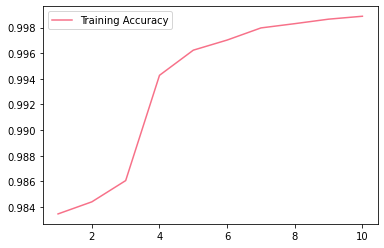

In [63]:
import seaborn as sns
with sns.color_palette("husl"):
  
    sns.lineplot([i for i in range(1,EPOCHS + 1)], train_acc_list, label = 'Training Accuracy')
    sns.lineplot([i for i in range(1,EPOCHS + 1)], val_20, label = 'ResNet-20')
    plt.plot([i for i in range(1,EPOCHS + 1)], val_44, label = 'ResNet-44')
    plt.plot([i for i in range(1,EPOCHS + 1)], val_16, label = 'VGG-16')
    plt.plot([i for i in range(1,EPOCHS + 1)], val_13, label = 'VGG-13')
    plt.legend()
    plt.title('Validation Accuracy on MNIST')